In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
import tarfile

In [0]:
bs = 64

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# 1. Load data

In [6]:
!wget https://www.dropbox.com/s/ghfhjtoh1z59xeb/wildfire_smoke_data.tar

--2020-02-24 07:23:56--  https://www.dropbox.com/s/ghfhjtoh1z59xeb/wildfire_smoke_data.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ghfhjtoh1z59xeb/wildfire_smoke_data.tar [following]
--2020-02-24 07:23:56--  https://www.dropbox.com/s/raw/ghfhjtoh1z59xeb/wildfire_smoke_data.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8af8efa636e9b56aecf7eed7e1.dl.dropboxusercontent.com/cd/0/inline/AysYhrYgbKsKZKsyzVem5VyHLnuQLvC4SXD9w7jdZqEJrEoDhPJWaUjN0gdqxZW9wIzurKIZCHz-qhMMY0FXjEChrx0MVqoxUXB6E8C_VBCSy2MwZJY5JugY3E20oBZgWQQ/file# [following]
--2020-02-24 07:23:56--  https://uc8af8efa636e9b56aecf7eed7e1.dl.dropboxusercontent.com/cd/0/inline/AysYhrYgbKsKZKsyzVem5VyHLnuQLvC4SXD9w7jdZqEJrEoDhPJWaUjN0gdqxZW9wIzurKIZCHz-qhMMY

In [0]:
tarred_file = tarfile.open("wildfire_smoke_data.tar")
tarred_file.extractall()
tarred_file.close()

In [8]:
!cd wildfire_smoke_data/ && ls

models	train  validate


In [0]:
data = ImageDataBunch.from_folder("wildfire_smoke_data",
                                  train = 'train',
                                  valid='validate',
                                  ds_tfms=get_transforms(), 
                                  size=224, bs=bs).normalize(imagenet_stats)

Be careful! Need to be in the right directory before using ImageDataBunch.

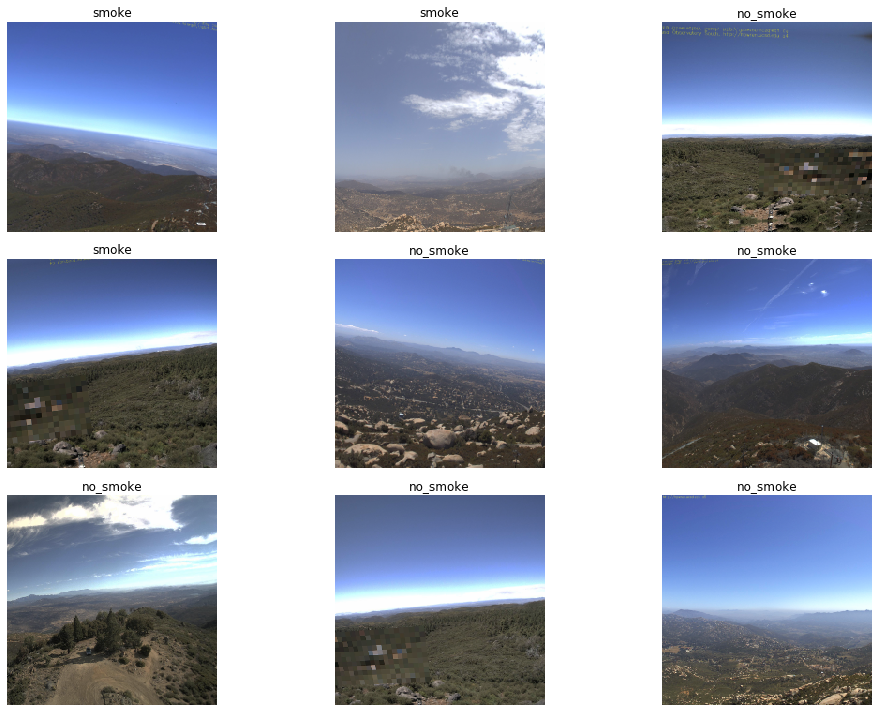

In [10]:
data.show_batch(rows=3, figsize=(15, 10))

It is difficult for human as well to detect smoke in some of those pictures.

# 2. Quick resnet model with pretrained weights



In [0]:
# TODO convert to fp16 after if results are good. Will result in smaller size for model on device
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate])

In [12]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.196069,1.361659,0.639098,0.360902,02:44
1,1.168369,1.078377,0.597744,0.402256,02:43
2,0.968016,0.549321,0.706767,0.293233,02:42
3,0.825127,0.526868,0.729323,0.270677,02:41
4,0.724078,0.534884,0.706767,0.293233,02:40


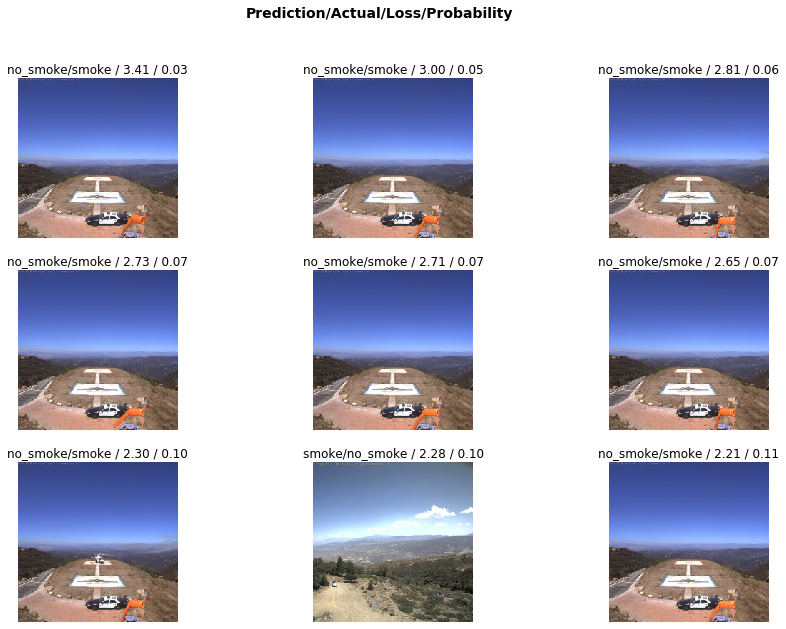

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

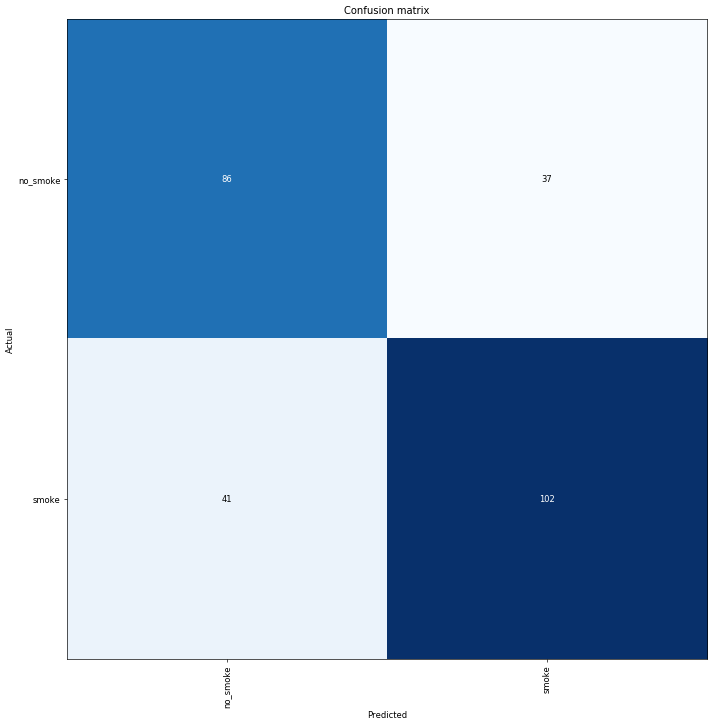

In [14]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# 3. Unfreezing 1st layer



In [0]:
learn.unfreeze()

In [16]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.662894,0.699044,0.710526,0.289474,02:42


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04
Min loss divided by 10: 8.32E-05


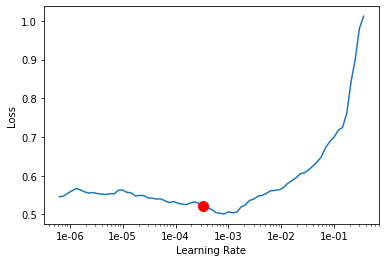

In [17]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [18]:
learn.fit_one_cycle(5,max_lr=slice(4.37E-05,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.535946,0.404566,0.789474,0.210526,02:42
1,0.467799,0.370807,0.819549,0.180451,02:42
2,0.400926,0.324948,0.864662,0.135338,02:41
3,0.347164,0.331775,0.875940,0.124060,02:42
4,0.311516,0.334814,0.853383,0.146617,02:42


In [19]:
learn.save("/content/gdrive/My Drive/stage-1", return_path=True)

PosixPath('/content/gdrive/My Drive/stage-1.pth')

# 4. Resizing and retraining

In [0]:
# data_512 = ImageDataBunch.from_folder("wildfire_smoke_data",
#                                   train = 'train',
#                                   valid='validate',
#                                   ds_tfms=get_transforms(), 
#                                   size=512, bs=bs).normalize(imagenet_stats)

In [0]:
# learn.data = data_512

In [0]:
# learn.freeze_to(-1)

In [0]:
# CUDA out of memory
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

In [24]:
!pip install --upgrade onnx-coreml

Requirement already up-to-date: onnx-coreml in /usr/local/lib/python3.6/dist-packages (1.2)


In [25]:
import torch
import torch.nn as nn
import numpy as np
from onnx_coreml import convert
from torch.autograd import Variable
import torch.onnx
import torchvision
import onnx
from onnx import onnx_pb

def check_onnx_compatible(model, model_name, sz, input_names, output_names):
    dummy_input = Variable(torch.randn(3, sz[0], sz[1])).cpu()
#     dummy_input = Variable(torch.randn(3, sz[0], sz[1])).half().cuda()

    torch.onnx.export(model, dummy_input, \
                      model_name, input_names = input_names, output_names = output_names, verbose=True)
    
    
    # Check again by onnx
    # Load the ONNX model
    onnx_model = onnx.load(model_name)

    # Check that the IR is well formed
    onnx.checker.check_model(onnx_model)

    # Print a human readable representation of the graph
#     onnx.helper.printable_graph(onnx_model.graph)
    print("Done")
    return onnx_model

In [0]:
class ImageScale(nn.Module):
    def __init__(self): 
        super().__init__()
        self.denominator = torch.full((3, sz[0], sz[1]), 255.0, device=torch.device("cpu"))
#         self.denominator = torch.full((3, sz[0], sz[1]), 255.0, device=torch.device("cuda"), dtype=torch.half)

    def forward(self, x): return torch.div(x, self.denominator).unsqueeze(0)

In [0]:
sz=[224,224]
final_model = [ImageScale()] + [learn.model] + [nn.Softmax(dim=-1)]
final_model = nn.Sequential(*final_model)

In [0]:
# final_model.eval()

In [39]:
model_name = "wildfireornot"

# Convert Pytorch model to onnx model & check if it is convertible
# onnx_model = check_onnx_compatible(final_model, model_name, sz, input_names=['image'], output_names=['wildfireornot'])
x = torch.randn(bs, 1, sz[0], sz[1], requires_grad=True)

torch.onnx.export(final_model, x, \
                      model_name, input_names=['image'], output_names=['wildfireornot'], verbose=True)

# torch.onnx.export(final_model,               # model being run
#                   x,                         # model input (or a tuple for multiple inputs)
#                   "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=10,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['input'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
#                                 'output' : {0 : 'batch_size'}})

RuntimeError: ignored